# Explore Binary GLM-HMM One State One Animal

**Goal:** replicate previously found results of GLM fits to PWM data with SSM package 


**Sub Goals**:

1. Single Animal Subset of Sessions
2. Single Animal All Sessions
3. Two Animal All Sessions
4. All Animals All Sessions
5. DMG -> SSM design matrix formating
6. Visuals for post fitting analysis (weights, comparison across animals)

This notebook will focus on fitting a single animal and the code necessary to do so.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ssm
from ssm.util import find_permutation

from multiglm.data.dataset_loader import *
from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *
from multiglm.visualizations.ssm_visualizer import *

%load_ext autoreload
%autoreload 2

sns.set_context('talk')

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Single Animal Session Subset

## Load In

In [2]:
animal_id = ["W075"]

df = DatasetLoader(
    animal_ids=["W051"], data_type="new_trained", relative_data_path="../../../data/"
).load_data()

Loading data for animal ids:  ['W051']


### Truncate


In [3]:
# Take a subset of the data
n_sessions = 20
session_min = df["session"].min()
session_stop = session_min + n_sessions

trunc_df = df.query("session >= @session_min and session < @session_stop")

## Design Matrix

In [4]:
dmg_config = {
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "session": lambda df: (copy(df.session)),
    "labels": binary_choice_labels(),
}

dmg = DesignMatrixGeneratorPWM(trunc_df, dmg_config, verbose=True)
X, y = dmg.create()

DMG: Creating data matrix with columns: dict_keys(['bias', 's_a', 's_b', 'session'])
DMG: Creating labels with column: choice.
DMG: Dropping 624 nan rows from data and labels.
DMG: Binary encoding labels.


In [5]:
X.head(), y[0:5]

(   bias       s_a       s_b  session
 3     1 -0.781914  0.005505      326
 4     1  0.899359  0.005505      326
 6     1  0.058723 -0.826305      326
 7     1  0.899359  0.005505      326
 8     1 -1.622550 -0.826305      326,
 array([0, 1, 1, 1, 1]))

### Format DMG for SSM

A jagged list of X, and y arrays where each array corresponds to data, or labels for a session. The number of trials per session can vary.

In [6]:
Xs, ys = prepare_data_for_ssm(X, y)

Xs[0].shape, ys[0].shape

((317, 3), (317,))

## Single State GLM-HMM

### Initialize

In [33]:
num_states = 1
obs_dim = 1
num_categories = 2  # left/right
input_dim = 3  # bias, s_a, s_b

In [34]:
glm_hmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

initial_weights = glm_hmm.params[2].copy()

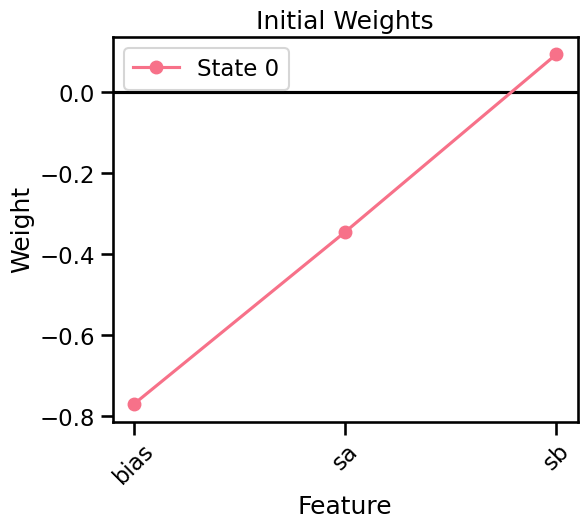

In [35]:
plot_bernoulli_weights_by_state(
    glm_hmm.params[2],
    feature_names=["bias", "sa", "sb"],
    title="Initial Weights",
)

### Fit - ERROR HERE
> Note the error occurs irrespective of the data being re-aggregated by session. D is the number of observed dimensions. Although this is set to 1 above, it appears there is something going on at compile and I will need to step through the code here.

In [32]:
N_iters = 200  # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glm_hmm.fit(
    y, #ys
    inputs=X[["bias", "s_a", "s_b"]].to_numpy(), #Xs
    method="em",
    num_iters=N_iters,
    tolerance=10**-4,
)

IndexError: tuple index out of range

In [ ]:
### Visualize

In [ ]:
### Interpretation of Results

# Single Animal All Sessions